 https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview (House Prices: Advanced Regression Techniques)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q /content/gdrive/MyDrive/house-prices-advanced-regression-techniques.zip

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

train_data = pd.read_csv('./train.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Сразу заметим несколько проблем:

1.   Id - модель будет попросту отвлекаться на эту колонку, которая не несет в себе никакой полезной для обучения информации
2.   Присутствуют NaN-значения

<Axes: xlabel='SalePrice', ylabel='Count'>

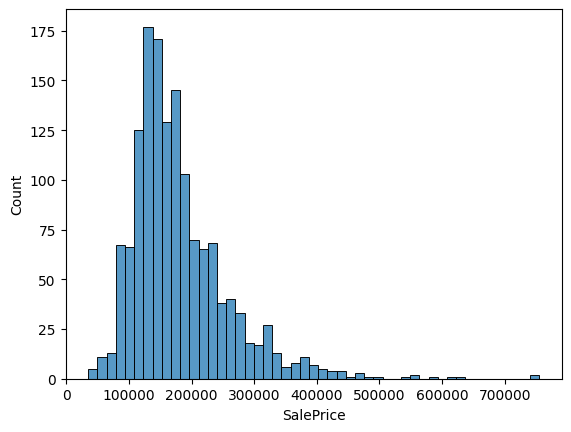

In [4]:
sns.histplot(train_data['SalePrice'])

<Axes: xlabel='SalePrice', ylabel='Count'>

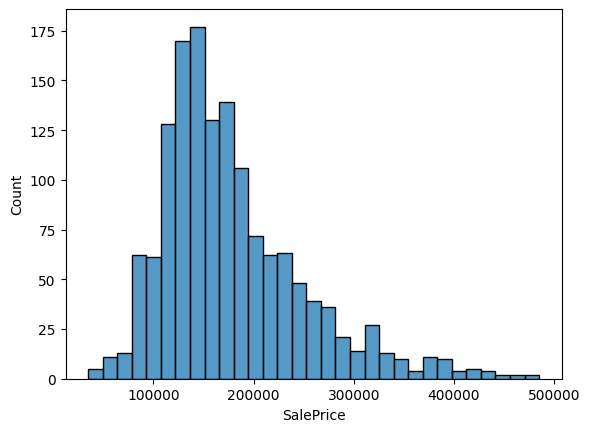

In [5]:
train_data = train_data[train_data['SalePrice'] < 500000]
sns.histplot(train_data['SalePrice'])

Очистили данные от нетипичных значений.

In [6]:
y = train_data['SalePrice']
X = train_data.drop(columns = ['SalePrice', 'Id'])

In [7]:
numeric_data = X.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()

X = X.fillna(numeric_data_mean)

Заполнили пропущенные данные средними значениями по столбцам.

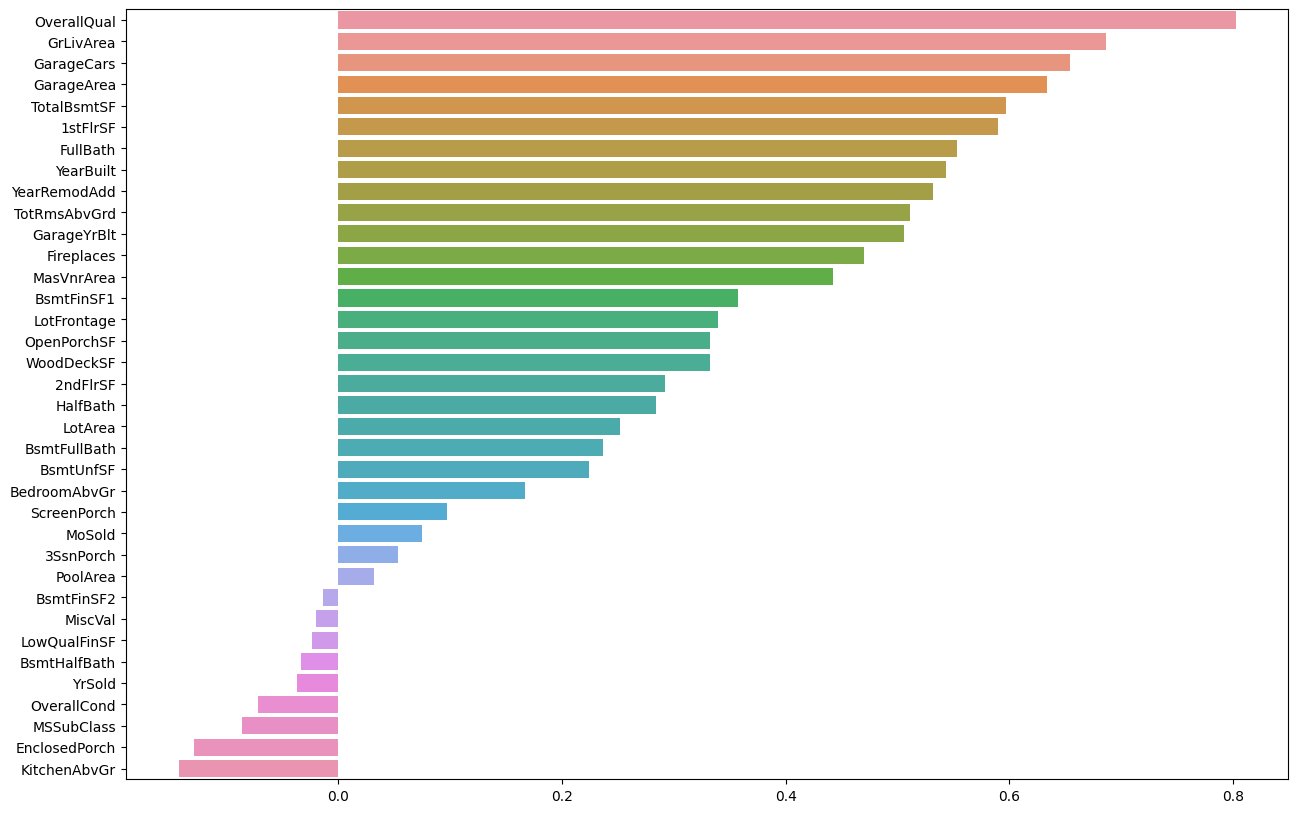

In [8]:
numeric_features = numeric_data.columns
correlations = train_data[numeric_features].corrwith(y).sort_values(ascending = False)
plot = sns.barplot(y = correlations.index, x = correlations)
plot.figure.set_size_inches(15, 10)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 10) #Подготовленные данные разделяем на train и validation.

In [10]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

In [28]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_val[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print(f'Test RMSE for just Ridge = {round(rmse(y_val, y_pred), 4)}')
print(f'Train RMSE for just Ridge = {round(rmse(y_train, y_train_pred), 4)}')

Test RMSE for just Ridge = 28307.1442
Train RMSE for just Ridge = 30228.4865


Первая обученная модель дает ошибку 28307.1442 рублей.

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

rmse_scorer = make_scorer(
    rmse,
    greater_is_better = False
)

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv = 10, scoring = rmse_scorer)
print(f'CV scores: {cv_scores}')
print(f'Mean RMSE for cross-validation Ridge model: {round(cv_scores.sum() / (-10), 4)}')

CV scores: [-27983.3349074  -26552.70726328 -40721.61923788 -29615.69098767
 -28918.93956143 -35518.86966812 -27369.74189431 -32085.31468814
 -22465.89039867 -58734.05423247]
Mean RMSE for cross-validation Ridge model: 32996.6163


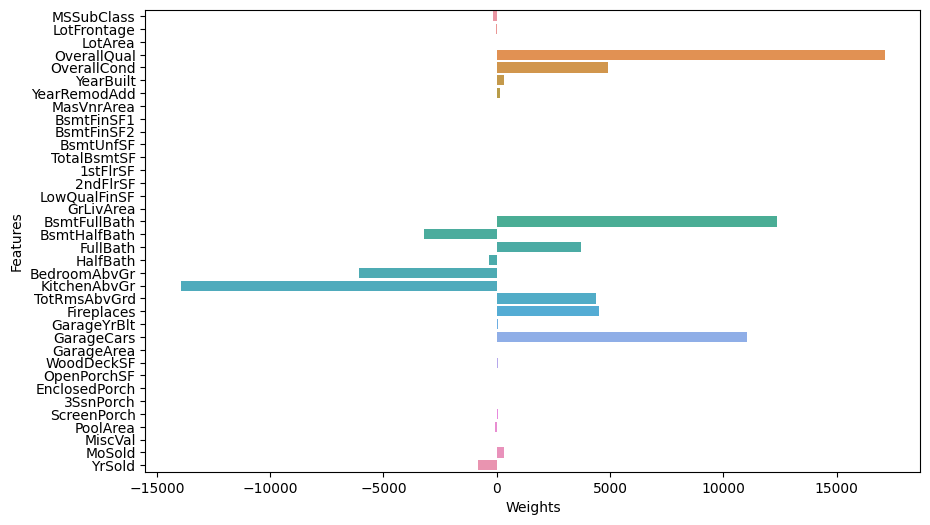

In [30]:
from matplotlib import pyplot as plt

def show_weights(coefs):
    df = pd.DataFrame({'Weights': coefs, 'Features': numeric_features})
    plt.figure(figsize = (10, 6))
    sns.barplot(x = 'Weights', y = 'Features', data = df, orient = 'h')
    plt.show()

show_weights(model.coef_)

Веса получились совершенно разных порядков. Для того, чтобы регуляризация происходила корректно, а веса уменьшались в равной степени, отмасштабируем признаки.

Train RMSE for Ridge using StandardScaler = 30228.3899
Val RMSE for Ridge using StandardScaler = 28319.87


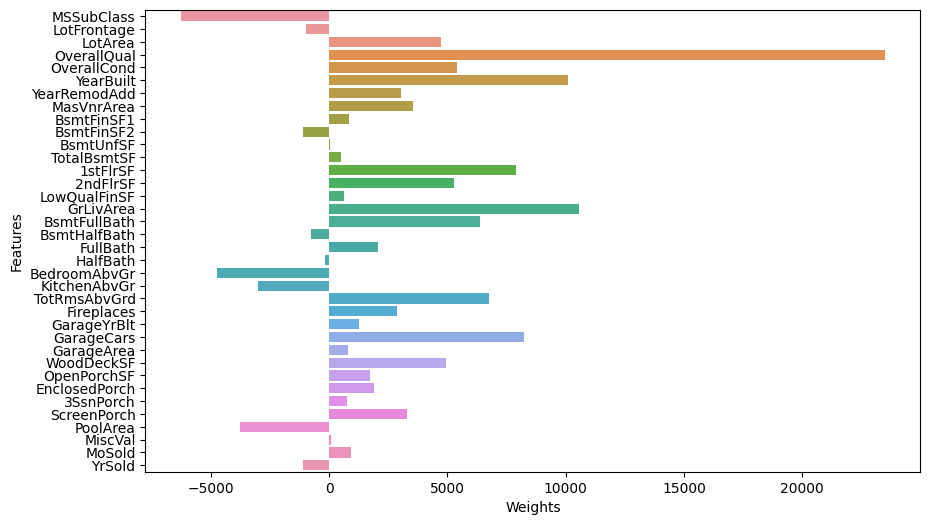

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_val_scaled = scaler.transform(X_val[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
y_train_pred = model.predict(X_train_scaled)

print(f'Train RMSE for Ridge using StandardScaler = {round(rmse(y_train, y_train_pred), 4)}')
print(f'Val RMSE for Ridge using StandardScaler = {round(rmse(y_val, y_pred), 4)}')
show_weights(model.coef_)

Как мы можем заметить, теперь в работу "включились" все параметры.

Best param for Ridge = 162.3777


Text(0, 0.5, 'CV score')

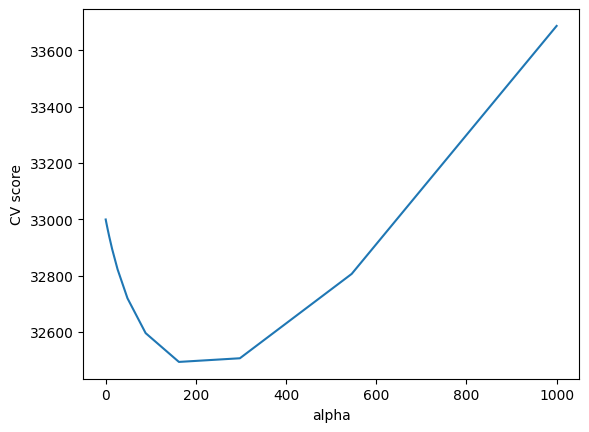

In [33]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20, base = 10) # Подбираем alpha по логарифмической сетке, чтобы узнать оптимальный порядок параметра
searcher = GridSearchCV(Ridge(), [{'alpha': alphas}], scoring = rmse_scorer, cv = 10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_['alpha']
print(f'Best param for Ridge = {round(best_alpha, 4)}')

plt.plot(alphas, -searcher.cv_results_['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('CV score')

In [34]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_val[numeric_features])
print(f'Val RMSE with best alpha = {round(rmse(y_val, y_pred), 4)}')

Val RMSE with best alpha = 28518.8998


28307.14 - лучший результат, которого удалось добиться при работе только с числовыми признаками.

In [39]:
categorical_features = list(X_train.dtypes[X_train.dtypes == 'object'].index) # Выделим категориальные признаки
X_train[categorical_features] = X_train[categorical_features].fillna('NotGiven')
X_val[categorical_features] = X_val[categorical_features].fillna('NotGiven')

In [43]:
X_train[categorical_features].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1058,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
707,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
909,RL,Pave,NotGiven,IR2,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
627,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Basment,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
941,RL,Pave,NotGiven,IR1,Lvl,AllPub,FR2,Gtl,Gilbert,RRNn,...,BuiltIn,RFn,TA,TA,Y,NotGiven,GdPrv,NotGiven,WD,Normal


In [48]:
pd.DataFrame(X_train[categorical_features]).nunique()

MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        7
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          6
Exterior1st      15
Exterior2nd      15
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64

In [49]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(f'RMSE for Ridge using all features = {round(rmse(y_val, y_pred), 4)}')

RMSE for Ridge using all features = 22752.2964


In [53]:
print(X_train.shape, column_transformer.transform(X_train).shape)

(1160, 79) (1160, 300)


Проблема One-hot кодирования в том, что признаков становится очень много, из-за чего возрастает риск переобучения модели. Попробуем занулить некоторые признаки, используя L1-регуляризацию.

In [59]:
from sklearn.linear_model import Lasso

pipeline = Pipeline([
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(f'RMSE for Lasso using all features = {round(rmse(y_val, y_pred), 4)}')

RMSE for Lasso using all features = 21293.3449


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1618679180.3043823, tolerance: 593587236.7671514
  model = cd_fast.sparse_enet_coordinate_descent(


In [66]:
print(f'Zero weights = {np.sum(pipeline.steps[-1][-1].coef_ == 0)}')

Zero weights = 32


L1-регуляризация не только улучшила результат, но и избавила модель от некоторых параметров.

Best param for Lasso = 127.4275


Text(0, 0.5, 'CV score')

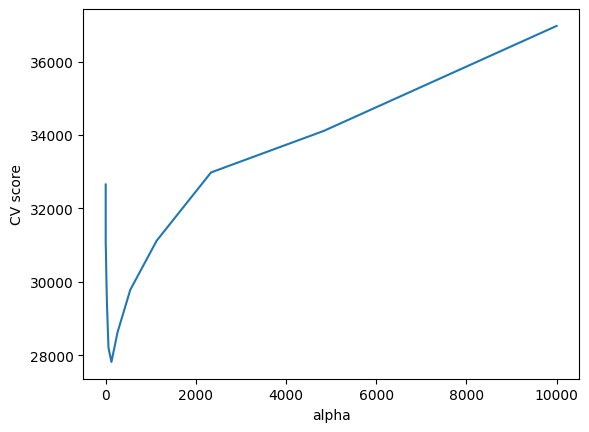

In [69]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(pipeline, [{'regression__alpha': alphas}], scoring = rmse_scorer, cv = 10, n_jobs = -1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_['regression__alpha']
print(f'Best param for Lasso = {round(best_alpha, 4)}')

plt.plot(alphas, -searcher.cv_results_['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('CV score')

In [70]:
pipeline = Pipeline([
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(f'RMSE for Lasso using all features and best alpha = {round(rmse(y_val, y_pred), 4)}')

RMSE for Lasso using all features and best alpha = 20806.0759


In [71]:
print(f'Zero weights = {np.sum(pipeline.steps[-1][-1].coef_ == 0)}')

Zero weights = 200


In [76]:
test_data = pd.read_csv('./test.csv')
ids = test_data['Id']
X_test = test_data.drop(columns = ['Id'])
X_test = X_test.fillna(numeric_data_mean)
X_test[categorical_features] = X_test[categorical_features].fillna('NotGiven')

my_submission = model.predict(X_test)
pd.DataFrame({'Id': ids, 'SalePrice': my_submission}).to_csv('./my_submission.csv', index = False)